In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import cv2
import random

# Suppress TensorFlow warnings (optional)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Check TensorFlow version
print(f"Using TensorFlow version: {tf.__version__}")


Using TensorFlow version: 2.15.0


In [2]:

classes = ['admin', 'ansci', 'ce', 'coe','cvm','dcst','dthm','foodtech']

# Arrays to hold the images and labels
X_train, Z_train = [], []
X_val, Z_val = [], []
X_test, Z_test = [], []

def assign_label(building_type):
    building_type = building_type.lower()  
    if building_type in classes:
        return classes.index(building_type)  
    else:
        print(f"Warning: Unrecognized building type: {building_type}")
        return None  

# Define dataset path
# Dynamically set the dataset path based on the project directory
project_dir = os.getcwd()  # Get the current working directory
inputdataset = os.path.join(project_dir, "dataset")

# Function to load images from a given folder
def load_images_from_folder(folder_path, X, Z):
    for building in os.listdir(folder_path):
        building_path = os.path.join(folder_path, building)

        if not os.path.isdir(building_path):  # Skip if it's not a folder
            continue

        label = assign_label(building)  # Assign label based on folder name
        if label is None:
            print(f"Skipping folder: {building_path} due to invalid label")
            continue  # Skip this folder if label is invalid

        for filename in os.listdir(building_path):
            img_path = os.path.join(building_path, filename)

            # Read the image using OpenCV
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)

            if img is None:
                print(f"Warning: {img_path} could not be loaded.")
                continue

            img = cv2.resize(img, (150,150))

            img = img / 255.0

            X.append(img)
            Z.append(label)

# Load images for training, validation, and test datasets
train_folder = os.path.join(inputdataset, 'training')
val_folder = os.path.join(inputdataset, 'validation')
test_folder = os.path.join(inputdataset, 'testing')

# Load images for each dataset
load_images_from_folder(train_folder, X_train, Z_train)
load_images_from_folder(val_folder, X_val, Z_val)
load_images_from_folder(test_folder, X_test, Z_test)

print(f"Number of training images: {len(X_train)}")
print(f"Number of training labels: {len(Z_train)}")
print(f"Number of validation images: {len(X_val)}")
print(f"Number of validation labels: {len(Z_val)}")
print(f"Number of test images: {len(X_test)}")
print(f"Number of test labels: {len(Z_test)}")


# Convert lists to numpy arrays
X_train = np.array(X_train)
Z_train = np.array(Z_train)

X_val = np.array(X_val)
Z_val = np.array(Z_val)

X_test = np.array(X_test)
Z_test = np.array(Z_test)

# Debugging: Print the shapes of the arrays
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Z_train: {Z_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of Z_val: {Z_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Z_test: {Z_test.shape}")

# Debugging: Print the first few labels to verify correctness
print(f"First 5 training labels (Z_train): {Z_train[:5]}")
print(f"Classes: {classes}")


# One-hot encode the labels
Y_train = to_categorical(Z_train, len(classes))
Y_val = to_categorical(Z_val, len(classes))
Y_test = to_categorical(Z_test, len(classes))

# Debugging: Print the shape of one-hot encoded labels
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of Y_val: {Y_val.shape}")
print(f"Shape of Y_test: {Y_test.shape}")


Number of training images: 799
Number of training labels: 799
Number of validation images: 320
Number of validation labels: 320
Number of test images: 718
Number of test labels: 718
Shape of X_train: (799, 150, 150, 3)
Shape of Z_train: (799,)
Shape of X_val: (320, 150, 150, 3)
Shape of Z_val: (320,)
Shape of X_test: (718, 150, 150, 3)
Shape of Z_test: (718,)
First 5 training labels (Z_train): [0 0 0 0 0]
Classes: ['admin', 'ansci', 'ce', 'coe', 'cvm', 'dcst', 'dthm', 'foodtech']
Shape of Y_train: (799, 8)
Shape of Y_val: (320, 8)
Shape of Y_test: (718, 8)


Index: 173, Label: 1, Image shape: (150, 150, 3)
Index: 372, Label: 3, Image shape: (150, 150, 3)
Index: 311, Label: 3, Image shape: (150, 150, 3)
Index: 452, Label: 4, Image shape: (150, 150, 3)
Index: 366, Label: 3, Image shape: (150, 150, 3)
Index: 367, Label: 3, Image shape: (150, 150, 3)
Index: 329, Label: 3, Image shape: (150, 150, 3)
Index: 272, Label: 2, Image shape: (150, 150, 3)
Index: 730, Label: 7, Image shape: (150, 150, 3)


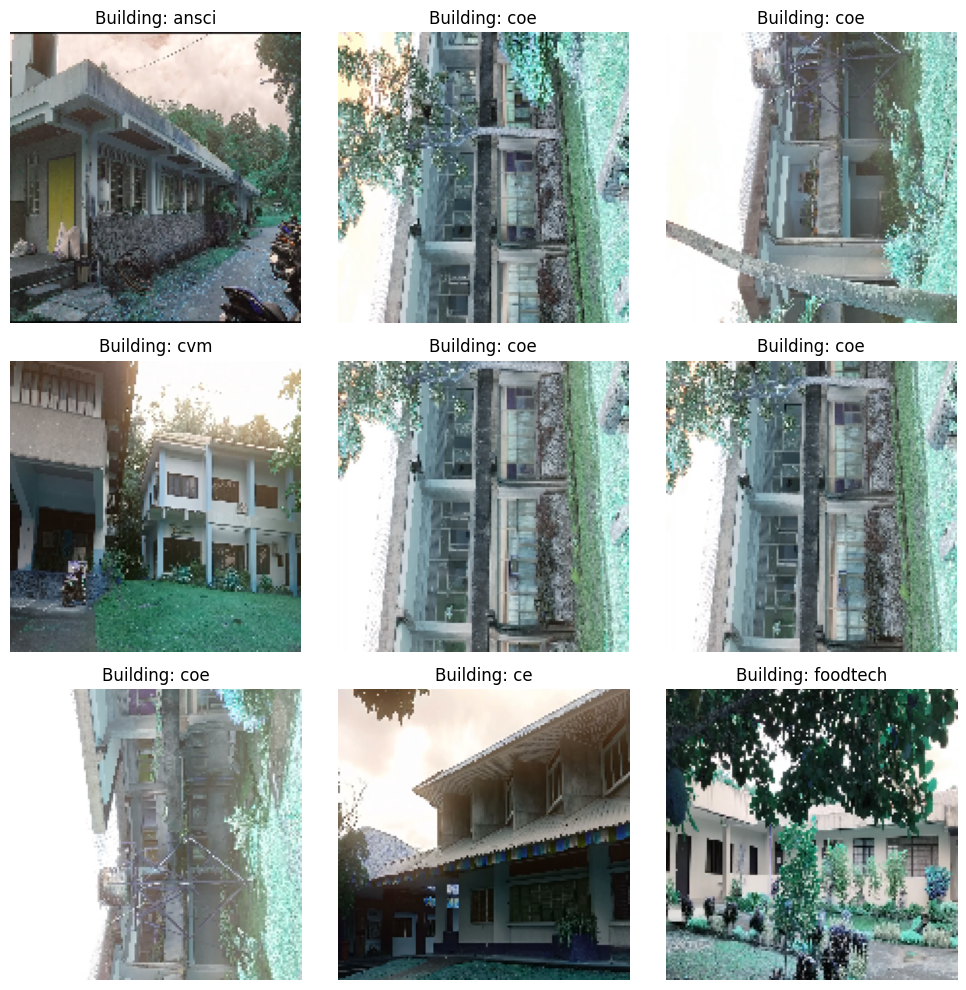

In [9]:
figure, axes = plt.subplots(3, 3)  # Create a 3x3 grid for image display
figure.set_size_inches(10, 10)  # Set the size of the figure

for row in range(3):
    for col in range(3):
        index = random.randint(0, len(X_train) - 1)  # Get a random index
        image = X_train[index]  # Get the image
        building_label = Z_train[index]  # Get the corresponding label

        # Debugging output
        print(f"Index: {index}, Label: {building_label}, Image shape: {image.shape}")

        # Plot the image on the grid
        axes[row, col].imshow(image)  # Display image
        axes[row, col].set_title(f"Building: {classes[building_label]}")  # Set title with label
        axes[row, col].axis('off')  # Hide axes for cleaner visualization

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(256, (3, 3),  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3, 3),  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))



In [4]:

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(8, activation = "softmax"))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

In [5]:

# Compile the model


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='val_loss'
)

# Create the data generator (add this before model.fit)
datagen = ImageDataGenerator()

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),  
    epochs=40,
    validation_data=(X_val, Y_val), 
    callbacks=[early_stopping,model_checkpoint]
)



X_train shape: (799, 150, 150, 3)
Y_train shape: (799, 8)
Epoch 1/40


25/25 [==============================] - 36s 1s/step - loss: 2.0802 - accuracy: 0.1252 - val_loss: 2.0753 - val_accuracy: 0.1281
Epoch 2/40
25/25 [==============================] - 25s 996ms/step - loss: 1.9892 - accuracy: 0.1715 - val_loss: 2.0576 - val_accuracy: 0.1781
Epoch 3/40
25/25 [==============================] - 27s 1s/step - loss: 1.8830 - accuracy: 0.2065 - val_loss: 1.9989 - val_accuracy: 0.2656
Epoch 4/40
25/25 [==============================] - 23s 901ms/step - loss: 1.8826 - accuracy: 0.2416 - val_loss: 2.0083 - val_accuracy: 0.2219
Epoch 5/40
25/25 [==============================] - 26s 1s/step - loss: 1.8131 - accuracy: 0.2403 - val_loss: 2.0021 - val_accuracy: 0.2156
Epoch 6/40
25/25 [==============================] - 24s 967ms/step - loss: 1.7637 - accuracy: 0.2891 - val_loss: 1.9626 - val_accuracy: 0.2219
Epoch 7/40
25/25 [==============================] - 27s 1s/step - loss: 1.7151 - accuracy:

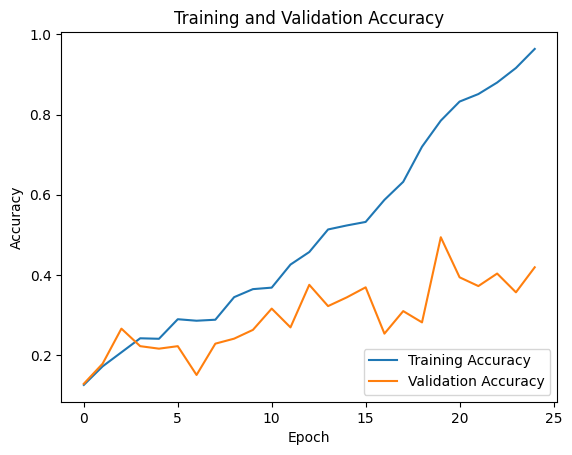

In [6]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.show()

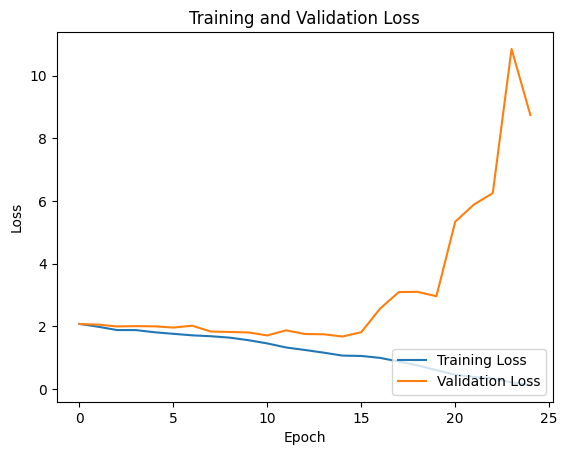

10/10 [==============================] - 3s 291ms/step - loss: 1.6775 - accuracy: 0.3438


In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')  
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()
val_loss, val_acc = model.evaluate(X_val, Y_val)

In [ ]:
model = tf.keras.models.load_model('best_model.keras')

test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Final Test Accuracy: {test_acc:.2f}")


ValueError: File not found: filepath=best_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
model.save('final_model.keras')

In [ ]:
image_path = '/Users/rigensuringa/Desktop/r.jpg'

# Load the image with the same size as the model's input size
img = load_img(image_path, target_size=(150, 150))  # Adjust (224, 224) to your model's input size
img_array = img_to_array(img)  # Convert image to a NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize to [0, 1] if your model expects normalized input

print(f"Image shape after preprocessing: {img_array.shape}")
model = tf.keras.models.load_model('final_model.keras')

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the predicted class index
confidence = np.max(predictions)  # Get confidence score

# Print the class name and confidence
print(f"Predicted plant type: {classes[predicted_class]}")
print(f"Confidence: {confidence:.2f}")

Image shape after preprocessing: (1, 150, 150, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted plant type: insulin
Confidence: 0.56
